In [64]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import re
import string
import pickle
import pickle
from collections import Counter

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,mean_squared_error
from sklearn.feature_extraction.text import  TfidfTransformer,TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier
import scikitplot as skplt



import nltk
import textstat
import spacy
from spacy.tokenizer import Tokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize


import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns
from bokeh.io import show,output_notebook
from bokeh.models import ColumnDataSource
from bokeh.palettes import Spectral3
from bokeh.plotting import figure

nlp = spacy.load("en_core_web_sm")
nlp.max_length = 9030000 
stopword = set(stopwords.words('english'))


### Load Dataset

In [2]:
df = pd.read_csv("amazon_reviews.txt", delimiter = "\t")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DOC_ID             21000 non-null  int64 
 1   LABEL              21000 non-null  object
 2   RATING             21000 non-null  int64 
 3   VERIFIED_PURCHASE  21000 non-null  object
 4   PRODUCT_CATEGORY   21000 non-null  object
 5   PRODUCT_ID         21000 non-null  object
 6   PRODUCT_TITLE      21000 non-null  object
 7   REVIEW_TITLE       21000 non-null  object
 8   REVIEW_TEXT        21000 non-null  object
dtypes: int64(2), object(7)
memory usage: 1.4+ MB


### Preprocessing Data and Feature Engineering

In [4]:
# quering for NaN values

df.isna().sum()

DOC_ID               0
LABEL                0
RATING               0
VERIFIED_PURCHASE    0
PRODUCT_CATEGORY     0
PRODUCT_ID           0
PRODUCT_TITLE        0
REVIEW_TITLE         0
REVIEW_TEXT          0
dtype: int64

In [5]:
# encoding the label to deceptive and truthful

df.loc[df["LABEL"] == "__label1__", "LABEL"] = 'Deceptive' 
df.loc[df["LABEL"] == "__label2__", "LABEL"] = 'Truthful'

In [75]:
df.describe()

,DOC_ID,RATING,percentage_of_capital,percent_of_numbers,offensive_word_count,sentence_length,review_length,Noun_Count,Adj_Count,Verb_Count,...,dale_readability_score,flesh_readability_score,gunning_fog_readability_index,compound,verified_purchase_encoded,product_category_encoded,product_id_encoded,label_encoded,verifed_encoded,comp_score_enc
count,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,...,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000,21000.000000
mean,10500.500000,4.127952,0.775638,0.222704,0.794714,4.442429,372.326429,15.975476,6.931619,13.684095,...,7.709253,80.786323,7.895402,0.580408,0.557048,14.500000,9579.037095,0.500000,0.557048,0.859905
std,6062.322162,1.278333,0.659474,0.454104,0.870981,4.156382,480.508503,21.431965,8.659486,16.626369,...,1.407443,12.695562,3.224640,0.504861,0.496747,8.655648,5457.552624,0.500012,0.496747,0.347094
min,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,98.000000,0.000000,0.000000,0.000000,...,0.310000,-90.930000,1.520000,-0.999900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5250.750000,4.000000,0.265957,0.000000,0.000000,2.000000,156.000000,7.000000,3.000000,6.000000,...,6.880000,73.880000,5.930000,0.421500,0.000000,7.000000,4860.750000,0.000000,0.000000,1.000000
50%,10500.500000,5.000000,0.704225,0.000000,1.000000,3.000000,236.000000,10.000000,5.000000,9.000000,...,7.620000,81.930000,7.430000,0.812600,1.000000,14.500000,9628.500000,0.500000,1.000000,1.000000
75%,15750.250000,5.000000,1.149425,0.315457,1.000000,5.000000,388.000000,17.000000,8.000000,15.000000,...,8.440000,89.080000,9.280000,0.929200,1.000000,22.000000,14345.250000,1.000000,1.000000,1.000000
max,21000.000000,5.000000,8.270677,8.000000,17.000000,112.000000,16188.000000,584.000000,224.000000,572.000000,...,21.230000,116.350000,75.620000,0.999500,1.000000,29.000000,18856.000000,1.000000,1.000000,1.000000


In [6]:
# function
def pos_tag(text,label):
    pos_df=pd.DataFrame(columns = ['Label','Word','count','POS'])

    doc = nlp(text)
    for token in doc:
        pos_df = pos_df.append({'Label':label.values,'WORD': token.text, 'POS': token.pos_}, ignore_index=True)
    return pos_df

In [7]:
array_Noun = []
array_Adj = []
array_Verb = []
array_Adv = []
array_Pro = []
array_Pre = []
array_Con = []
array_Nega = []

word_count=[]
array_first_person=[]
array_sercond_person=[]
person1_count=[]
person2_count=[]
person3_count=[]
poc=[]
percent_of_numbers_arr=[]
review_len=[]
sent_len=[]



prns=[]
negations = ['no', 'not', 'none', 'nobody', 'nothing', 'neither', 'nowhere', 'never', 'hardly', 'barely', 'scarcely']
urlPattern = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
userPattern = '@[^\s]+'
some = 'amp,today,tomorrow,going,girl'

In [8]:
def filter_pronouns(text):
    per1=0
    per2=0
    per3=0
    doc = nlp(text)
    prns=[]
    for t in doc:
      if t.morph.get('Person'):
          prns.append(t.morph.get('Person'))
    for i in range (0,len(prns)):
        if prns[i][0] =='1':
            per1+=1
        if prns[i][0] =='2':
            per2+=1
        if prns[i][0] =='3':
            per3+=1
    person1_count.append(per1)
    person2_count.append(per2)
    person3_count.append(per3)

In [9]:
def filter_offensive(text):
    Offensive_Words="2 girls 1 cup,2g1c,4r5e,5h1t,5hit,a_s_s,a55,acrotomophilia,alabama hot pocket,alaskan pipeline,anal,anilingus,anus,apeshit,ar5e,arrse,arse,arsehole,ass,ass-fucker,ass-hat,ass-jabber,ass-pirate,assbag,assbandit,assbanger,assbite,assclown,asscock,asscracker,asses,assface,assfuck,assfucker,assfukka,assgoblin,asshat,asshead,asshole,assholes,asshopper,assjacker,asslick,asslicker,assmonkey,assmunch,assmuncher,assnigger,asspirate,assshit,assshole,asssucker,asswad,asswhole,asswipe,auto erotic,autoerotic,axwound,b!tch,b00bs,b17ch,b1tch,babeland,baby batter,baby juice,ball gag,ball gravy,ball kicking,ball licking,ball sack,ball sucking,ballbag,balls,ballsack,bampot,bangbros,bareback,barely legal,barenaked,bastard,bastardo,bastinado,bbw,bdsm,beaner,beaners,beastial,beastiality,beaver cleaver,beaver lips,bellend,bestial,bestiality,bi+ch,biatch,big black,big breasts,big knockers,big tits,bimbos,birdlock,bitch,bitchass,bitcher,bitchers,bitches,bitchin,bitching,bitchtits,bitchy,black cock,blonde action,blonde on blonde action,bloody,blow job,blow your load,blowjob,blowjobs,blue waffle,blumpkin,boiolas,bollock,bollocks,bollok,bollox,bondage,boner,boob,boobs,booobs,boooobs,booooobs,booooooobs,booty call,breasts,breeder,brotherfucker,brown showers,brunette action,buceta,bugger,bukkake,bulldyke,bullet vibe,bullshit,bum,bumblefuck,bung hole,bunghole,bunny fucker,busty,butt,butt plug,butt-pirate,buttcheeks,buttfucka,buttfucker,butthole,buttmuch,buttplug,c0ck,c0cksucker,camel toe,camgirl,camslut,camwhore,carpet muncher,carpetmuncher,cawk,chesticle,chinc,chink,choad,chocolate rosebuds,chode,cipa,circlejerk,cl1t,cleveland steamer,clit,clitface,clitfuck,clitoris,clits,clover clamps,clusterfuck,cnut,cock,cock-sucker,cockass,cockbite,cockburger,cockeye,cockface,cockfucker,cockhead,cockjockey,cockknoker,cocklump,cockmaster,cockmongler,cockmongruel,cockmonkey,cockmunch,cockmuncher,cocknose,cocknugget,cocks,cockshit,cocksmith,cocksmoke,cocksmoker,cocksniffer,cocksuck,cocksucked,cocksucker,cocksucking,cocksucks,cocksuka,cocksukka,cockwaffle,cok,cokmuncher,coksucka,coochie,coochy,coon,coons,cooter,coprolagnia,coprophilia,cornhole,cox,cracker,crap,creampie,crotte,cum,cumbubble,cumdumpster,cumguzzler,cumjockey,cummer,cumming,cums,cumshot,cumslut,cumtart,cunilingus,cunillingus,cunnie,cunnilingus,cunt,cuntass,cuntface,cunthole,cuntlick,cuntlicker,cuntlicking,cuntrag,cunts,cuntslut,cyalis,cyberfuc,cyberfuck,cyberfucked,cyberfucker,cyberfuckers,cyberfucking,d1ck,dago,damn,darkie,date rape,daterape,deep throat,deepthroat,deggo,dendrophilia,dick,dick-sneeze,dickbag,dickbeaters,dickface,dickfuck,dickfucker,dickhead,dickhole,dickjuice,dickmilk ,dickmonger,dicks,dickslap,dicksucker,dicksucking,dicktickler,dickwad,dickweasel,dickweed,dickwod,dike,dildo,dildos,dingleberries,dingleberry,dink,dinks,dipshit,dirsa,dirty pillows,dirty sanchez,dlck,dog style,dog-fucker,doggie style,doggiestyle,doggin,dogging,doggy style,doggystyle,dolcett,domination,dominatrix,dommes,donkey punch,donkeyribber,doochbag,dookie,doosh,double dong,double penetration,doublelift,douche,douche-fag,douchebag,douchewaffle,dp action,dry hump,duche,dumass,dumb ass,dumbass,dumbcunt,dumbfuck,dumbshit,dumshit,dvda,dyke,eat my ass,ecchi,ejaculate,ejaculated,ejaculates,ejaculating,ejaculatings,ejaculation,ejakulate,erotic,erotism,escort,eunuch,f u c k,f u c k e r,f_u_c_k,f4nny,fag,fagbag,fagfucker,fagging,faggit,faggitt,faggot,faggotcock,faggs,fagot,fagots,fags,fagtard,fanny,fannyflaps,fannyfucker,fanyy,fatass,fcuk,fcuker,fcuking,fecal,feck,fecker,felch,felching,fellate,fellatio,feltch,female squirting,femdom,figging,fingerbang,fingerfuck,fingerfucked,fingerfucker,fingerfuckers,fingerfucking,fingerfucks,fingering,fistfuck,fistfucked,fistfucker,fistfuckers,fistfucking,fistfuckings,fistfucks,fisting,flamer,flange,foah,fook,fooker,foot fetish,footjob,frotting,fuck,fuck buttons,fuck off,fucka,fuckass,fuckbag,fuckboy,fuckbrain,fuckbutt,fuckbutter,fucked,fucker,fuckers,fuckersucker,fuckface,fuckhead,fuckheads,fuckhole,fuckin,fucking,fuckings,fuckingshitmotherfucker,fuckme,fucknut,fucknutt,fuckoff,fucks,fuckstick,fucktard,fucktards,fucktart,fucktwat,fuckup,fuckwad,fuckwhit,fuckwit,fuckwitt,fudge packer,fudgepacker,fuk,fuker,fukker,fukkin,fuks,fukwhit,fukwit,futanari,fux,fux0r,g-spot,gang bang,gangbang,gangbanged,gangbangs,gay,gay sex,gayass,gaybob,gaydo,gayfuck,gayfuckist,gaylord,gaysex,gaytard,gaywad,genitals,giant cock,girl on,girl on top,girls gone wild,goatcx,goatse,god damn,god-dam,god-damned,goddamn,goddamned,goddamnit,gokkun,golden shower,goo girl,gooch,goodpoop,gook,goregasm,gringo,grope,group sex,guido,guro,hand job,handjob,hard core,hard on,hardcore,hardcoresex,heeb,hell,hentai,heshe,ho,hoar,hoare,hoe,hoer,homo,homodumbshit,homoerotic,honkey,hooker,hore,horniest,horny,hot carl,hot chick,hotsex,how to kill,how to murder,huge fat,humping,incest,intercourse,jack Off,jack-off,jackass,jackoff,jaggi,jagoff,jail bait,jailbait,jap,jelly donut,jerk off,jerk-off,jerkass,jigaboo,jiggaboo,jiggerboo,jism,jiz,jizm,jizz,juggs,jungle bunny,junglebunny,kawk,kike,kinbaku,kinkster,kinky,knob,knobbing,knobead,knobed,knobend,knobhead,knobjocky,knobjokey,kock,kondum,kondums,kooch,kootch,kraut,kum,kummer,kumming,kums,kunilingus,kunja,kunt,kyke,l3i+ch,l3itch,labia,lameass,lardass,leather restraint,leather straight jacket,lemon party,lesbian,lesbo,lezzie,lmfao,lolita,lovemaking,lust,lusting,m0f0,m0fo,m45terbate,ma5terb8,ma5terbate,make me come,male squirting,masochist,master-bate,masterb8,masterbat,masterbat3,masterbate,masterbation,masterbations,masturbate,mcfagget,menage a trois,mick,milf,minge,missionary position,mo-fo,mof0,mofo,mothafuck,mothafucka,mothafuckas,mothafuckaz,mothafucked,mothafucker,mothafuckers,mothafuckin,mothafucking,mothafuckings,mothafucks,mother fucker,motherfuck,motherfucked,motherfucker,motherfuckers,motherfuckin,motherfucking,motherfuckings,motherfuckka,motherfucks,mound of venus,mr hands,muff,muff diver,muffdiver,muffdiving,munging,mutha,muthafecker,muthafuckker,muther,mutherfucker,n1gga,n1gger,nambla,nawashi,nazi,negro,neonazi,nig nog,nigaboo,nigg3r,nigg4h,nigga,niggah,niggas,niggaz,nigger,niggers,niglet,nimphomania,nipple,nipples,nob,nob jokey,nobhead,nobjocky,nobjokey,nsfw images,nude,nudity,numbnuts,nut sack,nutsack,nympho,nymphomania,octopussy,omorashi,one cup two girls,one guy one jar,orgasim,orgasims,orgasm,orgasms,orgy,p0rn,paedophile,paki,panooch,panties,panty,pawn,pecker,peckerhead,pedobear,pedophile,pegging,penis,penisbanger,penisfucker,penispuffer,phone sex,phonesex,phuck,phuk,phuked,phuking,phukked,phukking,phuks,phuq,piece of shit,pigfucker,pimpis,piss,piss pig,pissed,pissed off,pisser,pissers,pisses,pissflaps,pissin,pissing,pissoff,pisspig,playboy,pleasure chest,pole smoker,polesmoker,pollock,ponyplay,poof,poon,poonani,poonany,poontang,poop,poop chute,poopchute,poopuncher,porch monkey,porchmonkey,porn,porno,pornography,pornos,prick,pricks,prince albert piercing,pron,pthc,pube,pubes,punanny,punany,punta,pusse,pussi,pussies,pussy,pussylicking,pussys,pust,puto,queaf,queef,queer,queerbait,queerhole,quim,raghead,raging boner,rape,raping,rapist,rectum,renob,retard,reverse cowgirl,rimjaw,rimjob,rimming,rosy palm,rosy palm and her 5 sisters,ruski,rusty trombone,s.o.b.,s&m,sadism,sadist,sand nigger,sandler,sandnigger,sanger,santorum,scat,schlong,scissoring,screwing,scroat,scrote,scrotum,seks,semen,sex,sexo,sexy,shag,shagger,shaggin,shagging,shaved beaver,shaved pussy,shemale,shi+,shibari,shit,shitass,shitbag,shitbagger,shitblimp,shitbrains,shitbreath,shitcanned,shitcunt,shitdick,shite,shited,shitey,shitface,shitfaced,shitfuck,shitfull,shithead,shithole,shithouse,shiting,shitings,shits,shitspitter,shitstain,shitted,shitter,shitters,shittiest,shitting,shittings,shitty,shiz,shiznit,shota,shrimping,skank,skeet,skullfuck,slag,slanteye,slut,slutbag,sluts,smeg,smegma,smut,snatch,snowballing,sodomize,sodomy,son-of-a-bitch,spac,spic,spick,splooge,splooge moose,spooge,spook,spread legs,spunk,strap on,strapon,strappado,strip club,style doggy,suck,suckass,sucks,suicide girls,sultry women,swastika,swinger,t1tt1e5,t1tties,tainted love,tard,taste my,tea bagging,teets,teez,testical,testicle,threesome,throating,thundercunt,tied up,tight white,tit,titfuck,tits,titt,tittie5,tittiefucker,titties,titty,tittyfuck,tittywank,titwank,tongue in a,topless,tosser,towelhead,tranny,tribadism,tub girl,tubgirl,turd,tushy,tw4t,twat,twathead,twatlips,twats,twatty,twatwaffle,twink,twinkie,two girls one cup,twunt,twunter,unclefucker,undressing,upskirt,urethra play,urophilia,v14gra,v1gra,va-j-j,vag,vagina,vajayjay,venus mound,viagra,vibrator,violet wand,vjayjay,vorarephilia,voyeur,vulva,w00se,wang,wank,wanker,wankjob,wanky,wet dream,wetback,white power,whoar,whore,whorebag,whoreface,willies,willy,wop,wrapping men,wrinkled starfish,xrated,xx,xxx,yaoi,yellow showers,yiffy,zoophilia,zubb,a$$,a$$hole,a55hole,ahole,anal impaler,anal leakage,analprobe,ass fuck,ass hole,assbang,assbanged,assbangs,assfaces,assh0le,beatch,bimbo,bitch tit,bitched,bloody hell,bootee,bootie,bull shit,bullshits,bullshitted,bullturds,bum boy,butt fuck,buttfuck,buttmunch,c-0-c-k,c-o-c-k,c-u-n-t,c.0.c.k,c.o.c.k.,c.u.n.t,caca,cacafuego,chi-chi man,child-fucker,clit licker,cock sucker,corksucker,corp whore,crackwhore,dammit,damned,damnit,darn,dick head,dick hole,dick shy,dick-ish,dickdipper,dickflipper,dickheads,dickish,f-u-c-k,f.u.c.k,fist fuck,fuck hole,fuck puppet,fuck trophy,fuck yo mama,fuck you,fuck-ass,fuck-bitch,fuck-tard,fuckedup,fuckmeat,fucknugget,fucktoy,fuq,gassy ass,h0m0,h0mo,ham flap,he-she,hircismus,holy shit,hom0,hoor,jackasses,jackhole,middle finger,moo foo,naked,p.u.s.s.y.,piss off,piss-off,rubbish,s-o-b,s0b,shit ass,shit fucker,shiteater,son of a bitch,son of a whore,two fingers,wh0re,wh0reface"
    offensiveWords=Offensive_Words.split(',')
    count=0
    for word in offensiveWords:
        if word in text:
            count+=1
    return count

In [10]:
def percent_of_numbers(rows):
    _length=len(rows)
    numbers=re.findall(r'\d+', rows)
    percent_of_numbers_arr.append(len(numbers)/_length*100)

In [11]:
def percentage_of_capitals(eos):
    _length=len(eos)
    capitals=re.findall(r'\b[A-Z]+(?:\s+[A-Z]+)*\b', eos)
    poc.append(len(capitals)/_length*100)

In [12]:
# https://jovian.ai/kamilpolak/sentiment-analysis-with-glove-and-lstm-a3c64
def filter_text(text):
  # Lower Casing
    text = re.sub(r"he's", "he is", text)
    text = re.sub(r"there's", "there is", text)
    text = re.sub(r"We're", "We are", text)
    text = re.sub(r"That's", "That is", text)
    text = re.sub(r"won't", "will not", text)
    text = re.sub(r"they're", "they are", text)
    text = re.sub(r"Can't", "Cannot", text)
    text = re.sub(r"wasn't", "was not", text)
    text = re.sub(r"don\x89Ûªt", "do not", text)
    text = re.sub(r"aren't", "are not", text)
    text = re.sub(r"isn't", "is not", text)
    text = re.sub(r"What's", "What is", text)
    text = re.sub(r"haven't", "have not", text)
    text = re.sub(r"hasn't", "has not", text)
    text = re.sub(r"There's", "There is", text)
    text = re.sub(r"He's", "He is", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"You're", "You are", text)
    text = re.sub(r"I'M", "I am", text)
    text = re.sub(r"shouldn't", "should not", text)
    text = re.sub(r"wouldn't", "would not", text)
    text = re.sub(r"i'm", "I am", text)
    text = re.sub(r"I\x89Ûªm", "I am", text)
    text = re.sub(r"I'm", "I am", text)
    text = re.sub(r"Isn't", "is not", text)
    text = re.sub(r"Here's", "Here is", text)
    text = re.sub(r"you've", "you have", text)
    text = re.sub(r"you\x89Ûªve", "you have", text)
    text = re.sub(r"we're", "we are", text)
    text = re.sub(r"what's", "what is", text)
    text = re.sub(r"couldn't", "could not", text)
    text = re.sub(r"we've", "we have", text)
    text = re.sub(r"it\x89Ûªs", "it is", text)
    text = re.sub(r"doesn\x89Ûªt", "does not", text)
    text = re.sub(r"It\x89Ûªs", "It is", text)
    text = re.sub(r"Here\x89Ûªs", "Here is", text)
    text = re.sub(r"who's", "who is", text)
    text = re.sub(r"I\x89Ûªve", "I have", text)
    text = re.sub(r"y'all", "you all", text)
    text = re.sub(r"can\x89Ûªt", "cannot", text)
    text = re.sub(r"would've", "would have", text)
    text = re.sub(r"it'll", "it will", text)
    text = re.sub(r"we'll", "we will", text)
    text = re.sub(r"wouldn\x89Ûªt", "would not", text)
    text = re.sub(r"We've", "We have", text)
    text = re.sub(r"he'll", "he will", text)
    text = re.sub(r"Y'all", "You all", text)
    text = re.sub(r"Weren't", "Were not", text)
    text = re.sub(r"Didn't", "Did not", text)
    text = re.sub(r"they'll", "they will", text)
    text = re.sub(r"they'd", "they would", text)
    text = re.sub(r"DON'T", "DO NOT", text)
    text = re.sub(r"That\x89Ûªs", "That is", text)
    text = re.sub(r"they've", "they have", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"should've", "should have", text)
    text = re.sub(r"You\x89Ûªre", "You are", text)
    text = re.sub(r"where's", "where is", text)
    text = re.sub(r"Don\x89Ûªt", "Do not", text)
    text = re.sub(r"we'd", "we would", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"weren't", "were not", text)
    text = re.sub(r"They're", "They are", text)
    text = re.sub(r"Can\x89Ûªt", "Cannot", text)
    text = re.sub(r"you\x89Ûªll", "you will", text)
    text = re.sub(r"I\x89Ûªd", "I would", text)
    text = re.sub(r"let's", "let us", text)
    text = re.sub(r"it's", "it is", text)
    text = re.sub(r"can't", "cannot", text)
    text = re.sub(r"don't", "do not", text)
    text = re.sub(r"you're", "you are", text)
    text = re.sub(r"i've", "I have", text)
    text = re.sub(r"that's", "that is", text)
    text = re.sub(r"i'll", "I will", text)
    text = re.sub(r"doesn't", "does not", text)
    text = re.sub(r"i'd", "I would", text)
    text = re.sub(r"didn't", "did not", text)
    text = re.sub(r"ain't", "am not", text)
    text = re.sub(r"you'll", "you will", text)
    text = re.sub(r"I've", "I have", text)
    text = re.sub(r"Don't", "do not", text)
    text = re.sub(r"I'll", "I will", text)
    text = re.sub(r"I'd", "I would", text)
    text = re.sub(r"Let's", "Let us", text)
    text = re.sub(r"you'd", "You would", text)
    text = re.sub(r"It's", "It is", text)
    text = re.sub(r"Ain't", "am not", text)
    text = re.sub(r"Haven't", "Have not", text)
    text = re.sub(r"Could've", "Could have", text)
    text = re.sub(r"youve", "you have", text)  
    text = re.sub(r"donå«t", "do not", text)  
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"yrs", "years", text)
    text = re.sub(r"hrs", "hours", text)
    text = re.sub(r"2morow|2moro", "tomorrow", text)
    text = re.sub(r"2day", "today", text)
    text = re.sub(r"4got|4gotten", "forget", text)
    text = re.sub(r"b-day|bday", "b-day", text)
    text = re.sub(r"mother's", "mother", text)
    text = re.sub(r"mom's", "mom", text)
    text = re.sub(r"dad's", "dad", text)
    text = re.sub(r"hahah|hahaha|hahahaha", "haha", text)
    text = re.sub(r"lmao|lolz|rofl", "lol", text)
    text = re.sub(r"thanx|thnx", "thanks", text)
    text = re.sub(r"goood", "good", text)
    text = re.sub(r"some1", "someone", text)
    text = re.sub(r"some1", "someone", text)
    text = text.lower()
    text=text[1:]
    # Removing all URls 
    text = re.sub(urlPattern,'',text)
    #Remove punctuations
    text = text.translate(str.maketrans("","",string.punctuation))
    #tokenizing words
    sent_tokens = sent_tokenize(text)
    for i in sent_tokens:
      word_tokens=word_tokenize(i)
      Nega = 0
      for word in word_tokens:
        if word in negations:
            Nega += 1

      tagged = nltk.pos_tag(word_tokens)
      counts = Counter(tag for word,tag in tagged)
      N = sum([counts[i] for i in counts.keys() if 'NN' in i])
      Adj = sum([counts[i] for i in counts.keys() if 'JJ' in i])
      Verb = sum([counts[i] for i in counts.keys() if 'VB' in i])
      Adv = sum([counts[i] for i in counts.keys() if 'RB' in i])
      Pre = sum([counts[i] for i in counts.keys() if 'IN' in i])
      Con = sum([counts[i] for i in counts.keys() if 'CC' in i])

      array_Noun.append(N)
      array_Adj.append(Adj)
      array_Verb.append(Verb)
      array_Adv.append(Adv)
      array_Pre.append(Pre)
      array_Con.append(Con)
      array_Nega.append(Nega)
    

    #tokenizing words
    tokens = word_tokenize(text)
    word_count.append(len(tokens))
    #tokens = [w for w in tokens if len(w)>2]
    #Removing Stop Words
    final_tokens = [w for w in tokens if w not in stopword]
    #reducing a word to its word stem 
    wordLemm = WordNetLemmatizer()
    finalwords=[]

    for w in final_tokens:
      if len(w)>1:
        word = wordLemm.lemmatize(w)
        finalwords.append(word)
    return ' '.join(finalwords)

In [13]:
def review_length(row):
    review_len.append(len(row))
    return review_len

In [14]:
def Number_of_sentences(x):
    tokens=sent_tokenize(x)
    sent_len.append(len(tokens))
    return sent_len

In [15]:
df['REVIEW_TEXT'].apply(lambda row: percentage_of_capitals(row))
df['percentage_of_capital']=poc
df['REVIEW_TEXT'].apply(lambda row: percent_of_numbers(row))
df['percent_of_numbers']=percent_of_numbers_arr
df['review_processed']=df['REVIEW_TEXT'].apply(lambda row: filter_text(row))

df['REVIEW_TEXT'].apply(lambda row: filter_pronouns(row))
df['offensive_word_count']=df['REVIEW_TEXT'].apply(lambda x : filter_offensive(x))

In [16]:
df['REVIEW_TEXT'].apply(lambda row: Number_of_sentences(row))
df['sentence_length']=sent_len
df['REVIEW_TEXT'].apply(lambda row: review_length(row))
df['review_length']=review_len

In [17]:
POS = ['Noun_Count', 'Adj_Count', 'Verb_Count', 'Adv_Count',  'Pre_Count', 'Con_Count',  'Nega_Count', 'Word_Count','person1_count','person2_count','person3_count']
Values = [array_Noun, array_Adj, array_Verb, array_Adv, array_Pro, array_Pre, array_Con, array_Nega, word_count,person1_count,person2_count,person3_count]
i = 0
for x in POS:
    df[x] = pd.Series(Values[i])
    df[x] = df[x].fillna(0)
    df[x] = df[x].astype(float)
    i += 1


In [18]:
df['dale_readability_score']=df['REVIEW_TEXT'].apply(lambda x: textstat.dale_chall_readability_score(x))
df['flesh_readability_score']=df['REVIEW_TEXT'].apply(lambda x: textstat.flesch_reading_ease(x))
df['gunning_fog_readability_index']=df['REVIEW_TEXT'].apply(lambda x: textstat.gunning_fog(x))

In [19]:
sia = SentimentIntensityAnalyzer()
df['sentiment_scores'] = df['REVIEW_TEXT'].apply(lambda review: sia.polarity_scores(review))
df['compound']  = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])
df['comp_score'] = df['compound'].apply(lambda c: 'pos' if c >=0 else 'neg')

In [20]:
le = preprocessing.LabelEncoder()
df['verified_purchase_encoded']=le.fit_transform(df['VERIFIED_PURCHASE'])
df['product_category_encoded']=le.fit_transform(df['PRODUCT_CATEGORY'])
df['product_id_encoded']=le.fit_transform(df['PRODUCT_ID'])

### Standardization

In [21]:
df.columns

Index(['DOC_ID', 'LABEL', 'RATING', 'VERIFIED_PURCHASE', 'PRODUCT_CATEGORY',
       'PRODUCT_ID', 'PRODUCT_TITLE', 'REVIEW_TITLE', 'REVIEW_TEXT',
       'percentage_of_capital', 'percent_of_numbers', 'review_processed',
       'offensive_word_count', 'sentence_length', 'review_length',
       'Noun_Count', 'Adj_Count', 'Verb_Count', 'Adv_Count', 'Pre_Count',
       'Con_Count', 'Nega_Count', 'Word_Count', 'person1_count',
       'person2_count', 'person3_count', 'dale_readability_score',
       'flesh_readability_score', 'gunning_fog_readability_index',
       'sentiment_scores', 'compound', 'comp_score',
       'verified_purchase_encoded', 'product_category_encoded',
       'product_id_encoded'],
      dtype='object')

In [22]:
sc=StandardScaler()
scaled_df=sc.fit_transform(df[['review_length', 'sentence_length', 'percent_of_numbers',
       'percentage_of_capital', 'Noun_Count', 'Adj_Count',
       'Verb_Count', 'Adv_Count', 'Pre_Count', 'Con_Count',
       'Nega_Count',  'Word_Count', 'person1_count',
       'person2_count', 'person3_count', 'dale_readability_score',
       'flesh_readability_score', 'gunning_fog_readability_index']])
linguistic_df=pd.DataFrame(scaled_df,columns=['review_length', 'sentence_length', 'percent_of_numbers',
       'percentage_of_capital', 'Noun_Count', 'Adj_Count',
       'Verb_Count', 'Adv_Count',  'Pre_Count', 'Con_Count',
        'Nega_Count',  'Word_Count', 'person1_count',
       'person2_count', 'person3_count', 'dale_readability_score',
       'flesh_readability_score', 'gunning_fog_readability_index'])
linguistic_df['label']=df['LABEL']

In [23]:
radar_df=linguistic_df.groupby('label')[['Noun_Count', 'Adj_Count',
       'Verb_Count', 'Adv_Count',  'Pre_Count', 'Con_Count',
       'Nega_Count',  'Word_Count', 'person1_count',
       'person2_count']].mean()
radar_df

,Noun_Count,Adj_Count,Verb_Count,Adv_Count,Pre_Count,Con_Count,Nega_Count,Word_Count,person1_count,person2_count
label,,,,,,,,,,
Deceptive,-0.119991,-0.106387,-0.105509,-0.089219,0.0,-0.120151,-0.103645,-0.097951,-0.115315,-0.016173
Truthful,0.119991,0.106387,0.105509,0.089219,0.0,0.120151,0.103645,0.097951,0.115315,0.016173


# Analysis

## 1.	How does POS tag properties associates to deceptive and Truthful review? 

In [24]:
radar_categories=radar_df.columns
fig=go.Figure()
fig.add_trace(go.Scatterpolar(
      r=radar_df.iloc[0].values,
      theta=radar_categories,
      fill='toself',
      name='Deceptive'
))

fig.add_trace(go.Scatterpolar(
      r=radar_df.iloc[1].values,
      theta=radar_categories,
      fill='toself',
      name='Truthful'
))

fig.update_layout(
  polar=dict(
    radialaxis=dict(
      visible=True,
      range=[-1, 0.5]
    )),
  showlegend=True,
  autosize=False,
  width=800,
  height=800,
)

fig.show()


In [25]:
linguistic_df

,review_length,sentence_length,percent_of_numbers,percentage_of_capital,Noun_Count,Adj_Count,Verb_Count,Adv_Count,Pre_Count,Con_Count,Nega_Count,Word_Count,person1_count,person2_count,person3_count,dale_readability_score,flesh_readability_score,gunning_fog_readability_index,label
0,-0.533461,-0.587647,-0.490436,-1.176174,-0.512120,-0.685001,-0.582468,-0.242157,0.0,-0.520110,-0.786333,-0.653382,-0.537982,-0.849398,0.701351,-4.582357,1.678869,-1.021969,Deceptive
1,0.065918,-0.587647,-0.490436,-1.176174,-0.092176,0.354346,0.079148,0.035167,0.0,0.075799,0.326703,0.507105,0.003669,-0.406014,-0.377730,1.492633,-1.905934,2.203275,Deceptive
2,-0.258745,0.134151,0.397545,0.658176,-0.372139,-0.223069,-0.101293,0.173830,0.0,-0.222156,0.326703,0.507105,-0.192248,0.037371,-0.377730,-1.015520,1.100700,-1.158421,Deceptive
3,-0.333668,-0.106448,-0.490436,0.969670,-0.372139,-0.338552,-0.161440,-0.103495,0.0,-0.420792,-0.229815,-0.073138,-0.307492,-0.184321,-0.377730,-0.212627,0.386260,-0.519575,Deceptive
4,-0.086008,-0.347048,-0.490436,0.198203,-0.045516,-0.107586,-0.221587,-0.380819,0.0,0.175117,0.048444,-0.653382,-0.053954,0.259063,-0.377730,-0.418679,-0.492808,0.844951,Deceptive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-0.566760,-0.347048,-0.490436,3.373014,-0.465460,-0.454035,-0.582468,-0.380819,0.0,-0.619428,-0.786333,-0.073138,-0.572556,-0.184321,-0.377730,-0.511048,2.038846,-1.580184,Truthful
20996,-0.535542,-0.587647,-0.490436,0.142432,-0.232158,-0.685001,-0.702762,-0.658143,0.0,-0.222156,-0.786333,-0.653382,-0.514933,-0.406014,-0.377730,0.242109,1.599312,-0.897921,Truthful
20997,-0.156768,-0.347048,-0.490436,0.866110,-0.278818,0.354346,-0.161440,-0.103495,0.0,-0.023519,-0.229815,-0.653382,-0.169199,0.037371,-0.377730,-0.795258,0.146801,-0.491664,Truthful
20998,-0.177580,0.374751,-0.490436,0.937270,-0.138837,0.007897,-0.101293,-0.658143,0.0,-0.023519,-0.786333,-0.073138,-0.146150,0.037371,-0.377730,-0.809468,1.156627,-1.031272,Truthful


In [26]:
linguistic_df

,review_length,sentence_length,percent_of_numbers,percentage_of_capital,Noun_Count,Adj_Count,Verb_Count,Adv_Count,Pre_Count,Con_Count,Nega_Count,Word_Count,person1_count,person2_count,person3_count,dale_readability_score,flesh_readability_score,gunning_fog_readability_index,label
0,-0.533461,-0.587647,-0.490436,-1.176174,-0.512120,-0.685001,-0.582468,-0.242157,0.0,-0.520110,-0.786333,-0.653382,-0.537982,-0.849398,0.701351,-4.582357,1.678869,-1.021969,Deceptive
1,0.065918,-0.587647,-0.490436,-1.176174,-0.092176,0.354346,0.079148,0.035167,0.0,0.075799,0.326703,0.507105,0.003669,-0.406014,-0.377730,1.492633,-1.905934,2.203275,Deceptive
2,-0.258745,0.134151,0.397545,0.658176,-0.372139,-0.223069,-0.101293,0.173830,0.0,-0.222156,0.326703,0.507105,-0.192248,0.037371,-0.377730,-1.015520,1.100700,-1.158421,Deceptive
3,-0.333668,-0.106448,-0.490436,0.969670,-0.372139,-0.338552,-0.161440,-0.103495,0.0,-0.420792,-0.229815,-0.073138,-0.307492,-0.184321,-0.377730,-0.212627,0.386260,-0.519575,Deceptive
4,-0.086008,-0.347048,-0.490436,0.198203,-0.045516,-0.107586,-0.221587,-0.380819,0.0,0.175117,0.048444,-0.653382,-0.053954,0.259063,-0.377730,-0.418679,-0.492808,0.844951,Deceptive
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,-0.566760,-0.347048,-0.490436,3.373014,-0.465460,-0.454035,-0.582468,-0.380819,0.0,-0.619428,-0.786333,-0.073138,-0.572556,-0.184321,-0.377730,-0.511048,2.038846,-1.580184,Truthful
20996,-0.535542,-0.587647,-0.490436,0.142432,-0.232158,-0.685001,-0.702762,-0.658143,0.0,-0.222156,-0.786333,-0.653382,-0.514933,-0.406014,-0.377730,0.242109,1.599312,-0.897921,Truthful
20997,-0.156768,-0.347048,-0.490436,0.866110,-0.278818,0.354346,-0.161440,-0.103495,0.0,-0.023519,-0.229815,-0.653382,-0.169199,0.037371,-0.377730,-0.795258,0.146801,-0.491664,Truthful
20998,-0.177580,0.374751,-0.490436,0.937270,-0.138837,0.007897,-0.101293,-0.658143,0.0,-0.023519,-0.786333,-0.073138,-0.146150,0.037371,-0.377730,-0.809468,1.156627,-1.031272,Truthful


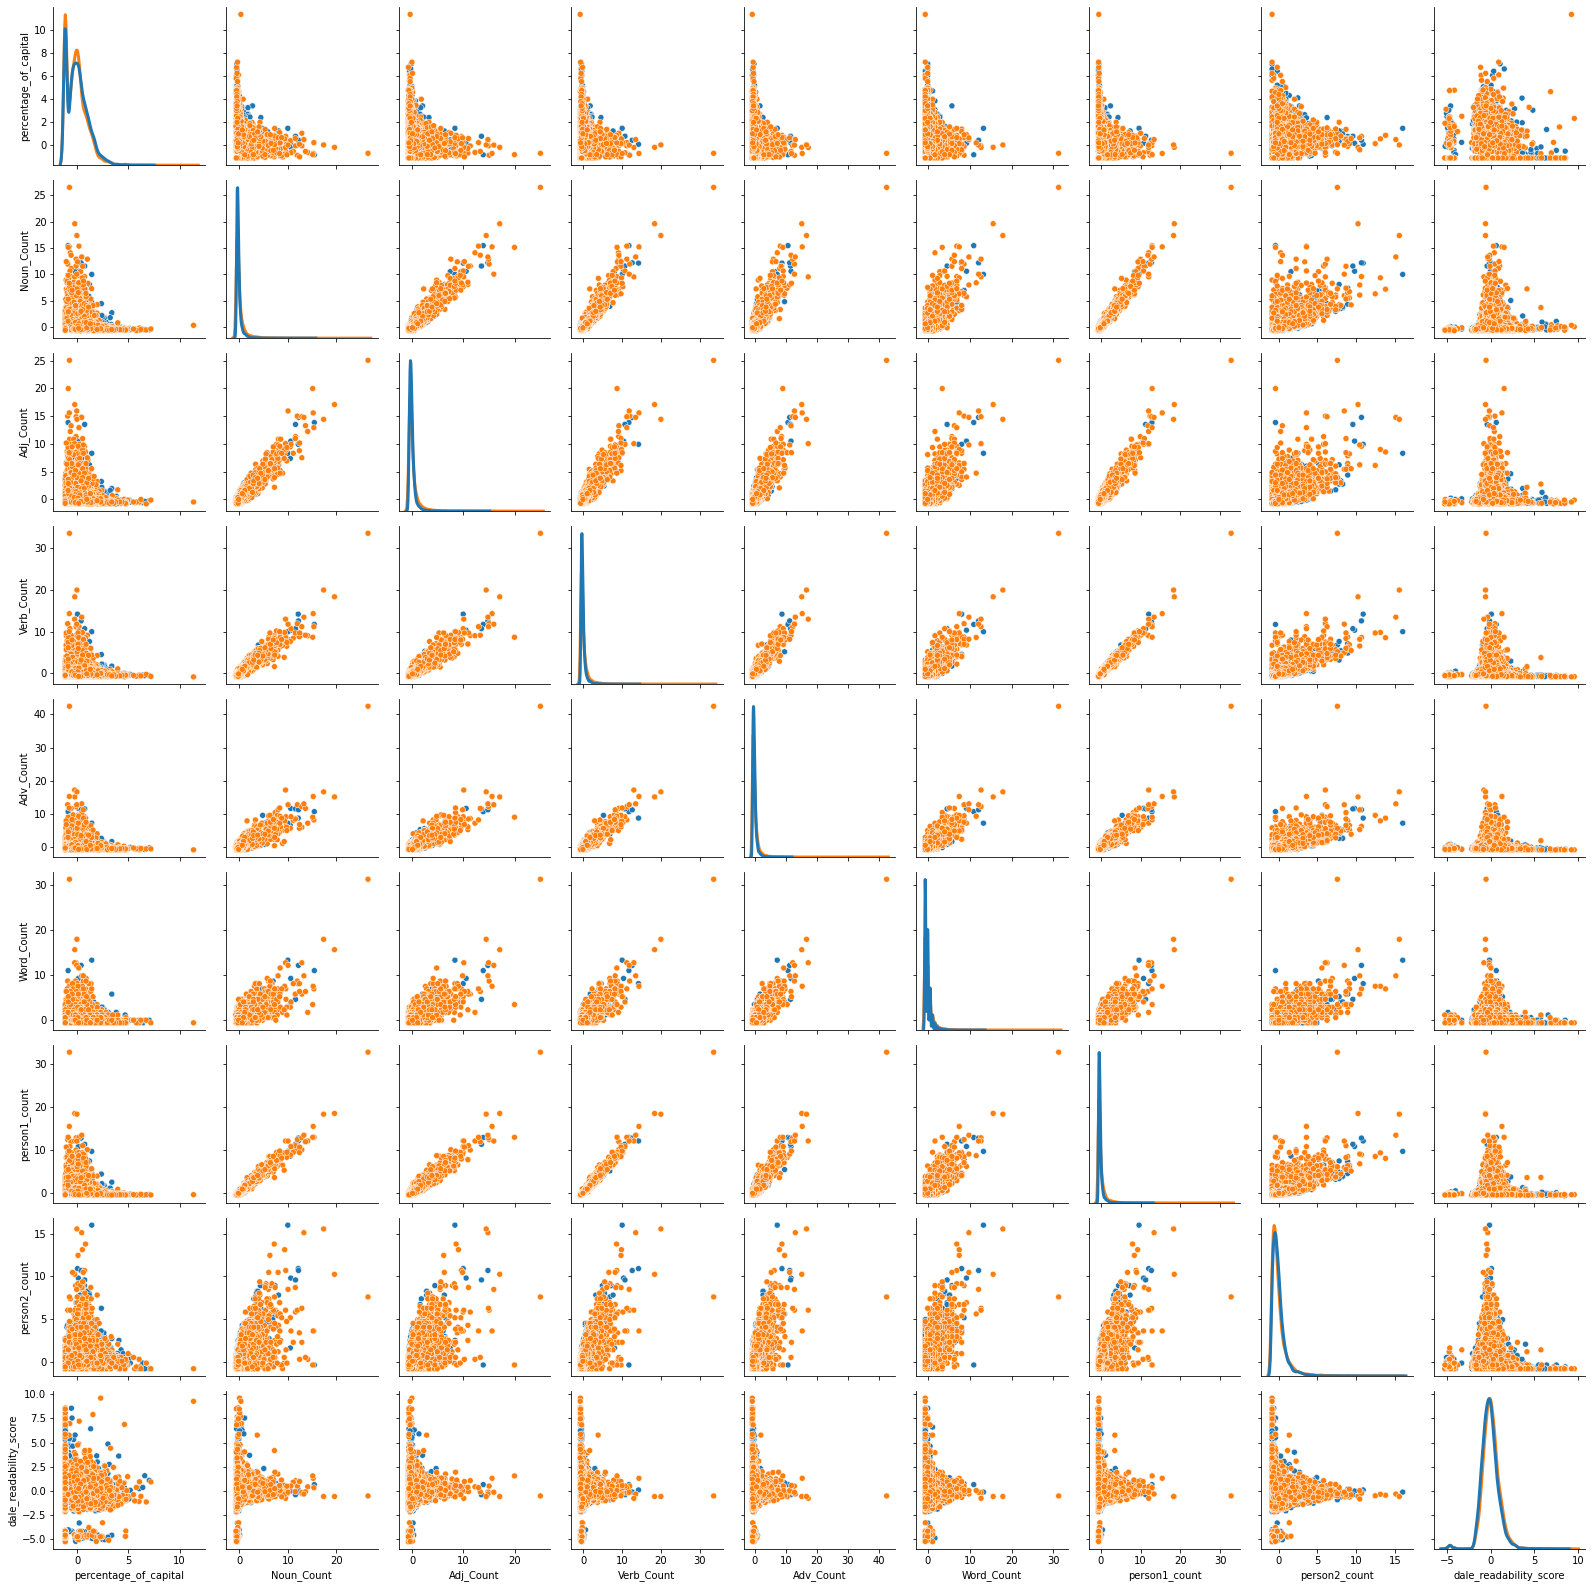

In [32]:
g=sns.PairGrid(linguistic_df,hue='label',diag_sharey=False, x_vars=['percentage_of_capital', 'Noun_Count', 'Adj_Count',
       'Verb_Count', 'Adv_Count', 'Word_Count', 'person1_count','person2_count','dale_readability_score'],y_vars=['percentage_of_capital', 'Noun_Count', 'Adj_Count',
       'Verb_Count', 'Adv_Count', 'Word_Count', 'person1_count','person2_count','dale_readability_score'])
g.map_diag(sns.kdeplot,lw=3)
g.map_offdiag(sns.scatterplot)

## 2. How does the deceptive review’s sentiment polarity for product categories varies in comparison to Truthful reviews? 

In [33]:
positive_sen=df[(df['comp_score']== "pos")]
negative_sen=df[ (df['comp_score']== "neg")]
truth_pos=positive_sen.groupby('PRODUCT_CATEGORY',as_index=False).apply(lambda x: pd.Series(dict(
    truthful=(x.LABEL == 'Deceptive').sum(),
    positive=(x.compound).sum()/x.compound.shape[0],
)))
fake_pos=positive_sen.groupby('PRODUCT_CATEGORY',as_index=False).apply(lambda x: pd.Series(dict(
    deceptive=(x.LABEL == 'Truthful').sum(),
    positive=(x.compound).sum()/x.compound.shape[0],
)))
truth_neg=negative_sen.groupby('PRODUCT_CATEGORY',as_index=False).apply(lambda x: pd.Series(dict(
    Truthful=(x.LABEL == 'Deceptive').sum(),
    negative=(x.compound).sum()/x.compound.shape[0],
)))
fake_neg=negative_sen.groupby('PRODUCT_CATEGORY',as_index=False).apply(lambda x: pd.Series(dict(
    deceptive=(x.LABEL == 'Truthful').sum(),
    negative=(x.compound).sum()/x.compound.shape[0],
)))
fake_neg=fake_neg.head(10)
truth_pos=truth_pos.head(10)
truth_neg=truth_neg.head(10)
fake_pos=fake_pos.head(10)


In [34]:
_categories=fake_neg['PRODUCT_CATEGORY'].unique()
positive=positive_sen["compound"].values
neagative=negative_sen["compound"].values
labels=["deceptive","truthful"]
exports={'categories':_categories,
        'deceptive':fake_pos.positive.values,
        'truthful':truth_pos.positive.values
}
imports={'categories':_categories,
        'deceptive':fake_neg.negative.values,
        'truthful':truth_neg.negative.values
}
colors1 = ["#c9d9d3", "#718dbf"]
colors2 = ['#ffffbf', '#fc8d59']
output_notebook()
p = figure(y_range=_categories, height=250, x_range=(-3, 3), title="polarity score of positive/negative, by deceptive and truthful reviews",
           toolbar_location=None)

p.hbar_stack(labels, y='categories', height=0.9, color=colors1, source=ColumnDataSource(exports),
             legend_label=["%s positive" % x for x in labels])

p.hbar_stack(labels, y='categories', height=0.9, color=colors2, source=ColumnDataSource(imports),
             legend_label=["%s negative" % x for x in labels])
p.y_range.range_padding = 0.1
p.ygrid.grid_line_color = None
p.legend.location = "top_left"
p.axis.minor_tick_line_color = None
p.legend.glyph_height = 10
p.legend.glyph_width = 20
p.legend.label_text_font_size = '8px'
p.legend.label_height = 10
p.legend.label_width = 50

show(p)

Loading BokehJS ...

## 3. Will reviewer use offensive words during deceptive interaction while degrading the product

In [35]:
df

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,percentage_of_capital,...,person3_count,dale_readability_score,flesh_readability_score,gunning_fog_readability_index,sentiment_scores,compound,comp_score,verified_purchase_encoded,product_category_encoded,product_id_encoded
0,1,Deceptive,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",0.000000,...,2.0,1.26,102.10,4.60,"{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp...",0.4939,pos,0,20,988
1,2,Deceptive,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.000000,...,0.0,9.81,56.59,15.00,"{'neg': 0.063, 'neu': 0.793, 'pos': 0.144, 'co...",0.8019,pos,1,29,16286
2,3,Deceptive,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,1.209677,...,0.0,6.28,94.76,4.16,"{'neg': 0.029, 'neu': 0.792, 'pos': 0.179, 'co...",0.7897,pos,0,2,2463
3,4,Deceptive,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,1.415094,...,0.0,7.41,85.69,6.22,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0,18,6172
4,5,Deceptive,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.906344,...,0.0,7.12,74.53,10.62,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...",0.7964,pos,0,3,17440
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,20996,Truthful,4,Y,Shoes,B00BXYM8T8,"Madden Girl Women's Gettaw Pump,Red Patent,7.5...",wide width is great!,"I bought these for work. I have high arches, ...",3.000000,...,0.0,6.99,106.67,2.80,"{'neg': 0.0, 'neu': 0.863, 'pos': 0.137, 'comp...",0.4019,pos,1,22,12798
20996,20997,Truthful,4,Y,Shoes,B0014C2ORK,"crocs Unisex Classic Clog,Khaki,6 US Men's / 8...",Love crocs!,Crocs are one of only two brands of shoes that...,0.869565,...,0.0,8.05,101.09,5.00,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",0.6988,pos,1,22,3649
20997,20998,Truthful,5,Y,Shoes,B000EX8CCQ,Minnetonka Men's 703 Leather Laced Softsole Mo...,I love moccasins This fit like it was custom m...,I love moccasins This fit like it was custom ...,1.346801,...,0.0,6.59,82.65,6.31,"{'neg': 0.019, 'neu': 0.73, 'pos': 0.251, 'com...",0.9390,pos,1,22,2118
20998,20999,Truthful,5,Y,Shoes,B00748YHVE,Ariat Womens Unbridled Fatbaby 9 B Powder Brown,"This fit well, comfortable, best investment",I wish these were a little more durable. I got...,1.393728,...,0.0,6.57,95.47,4.57,"{'neg': 0.123, 'neu': 0.72, 'pos': 0.157, 'com...",0.4767,pos,1,22,9977


<AxesSubplot: xlabel='LABEL', ylabel='offensive_word_count'>

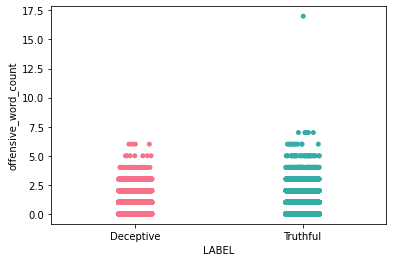

In [36]:
sns.stripplot(x="LABEL", y="offensive_word_count", data=df, palette="husl")


# 4. Is there deceiver in verified user in compared to truthful? 

In [37]:
verified_df=df.groupby('VERIFIED_PURCHASE').apply(lambda x: pd.Series(dict(
    Deceptive=(x.LABEL == 'Deceptive').sum()*100/x.shape[0],
    Truthful=(x.LABEL == 'Truthful').sum()*100/x.shape[0]
)))

In [38]:
verified_df

,Deceptive,Truthful
VERIFIED_PURCHASE,,
N,81.950118,18.049882
Y,24.593948,75.406052


<AxesSubplot: xlabel='VERIFIED_PURCHASE'>

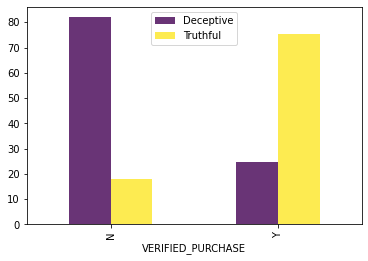

In [39]:
verified_df.plot(kind='bar',cmap="viridis",alpha=0.8)

## 5. How useful are the characteristics obtained from various readability score of review? Does it improve machine learning algorithm performance to detect deceptive reviews?

In [40]:
df['label_encoded']=le.fit_transform(df['LABEL'])

In [41]:
text_transformer = TfidfVectorizer(ngram_range=(2,2), max_features=2000)
encoded_text = text_transformer.fit_transform(df['review_processed'])
encoded_text=encoded_text.toarray()
encoded_text

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [42]:
df['verifed_encoded']=le.fit_transform(df.VERIFIED_PURCHASE)
df

,DOC_ID,LABEL,RATING,VERIFIED_PURCHASE,PRODUCT_CATEGORY,PRODUCT_ID,PRODUCT_TITLE,REVIEW_TITLE,REVIEW_TEXT,percentage_of_capital,...,flesh_readability_score,gunning_fog_readability_index,sentiment_scores,compound,comp_score,verified_purchase_encoded,product_category_encoded,product_id_encoded,label_encoded,verifed_encoded
0,1,Deceptive,4,N,PC,B00008NG7N,"Targus PAUK10U Ultra Mini USB Keypad, Black",useful,"When least you think so, this product will sav...",0.000000,...,102.10,4.60,"{'neg': 0.0, 'neu': 0.873, 'pos': 0.127, 'comp...",0.4939,pos,0,20,988,0,0
1,2,Deceptive,4,Y,Wireless,B00LH0Y3NM,Note 3 Battery : Stalion Strength Replacement ...,New era for batteries,Lithium batteries are something new introduced...,0.000000,...,56.59,15.00,"{'neg': 0.063, 'neu': 0.793, 'pos': 0.144, 'co...",0.8019,pos,1,29,16286,0,1
2,3,Deceptive,3,N,Baby,B000I5UZ1Q,"Fisher-Price Papasan Cradle Swing, Starlight",doesn't swing very well.,I purchased this swing for my baby. She is 6 m...,1.209677,...,94.76,4.16,"{'neg': 0.029, 'neu': 0.792, 'pos': 0.179, 'co...",0.7897,pos,0,2,2463,0,0
3,4,Deceptive,4,N,Office Products,B003822IRA,Casio MS-80B Standard Function Desktop Calculator,Great computing!,I was looking for an inexpensive desk calcolat...,1.415094,...,85.69,6.22,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0000,pos,0,18,6172,0,0
4,5,Deceptive,4,N,Beauty,B00PWSAXAM,Shine Whitening - Zero Peroxide Teeth Whitenin...,Only use twice a week,I only use it twice a week and the results are...,0.906344,...,74.53,10.62,"{'neg': 0.0, 'neu': 0.877, 'pos': 0.123, 'comp...",0.7964,pos,0,3,17440,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,20996,Truthful,4,Y,Shoes,B00BXYM8T8,"Madden Girl Women's Gettaw Pump,Red Patent,7.5...",wide width is great!,"I bought these for work. I have high arches, ...",3.000000,...,106.67,2.80,"{'neg': 0.0, 'neu': 0.863, 'pos': 0.137, 'comp...",0.4019,pos,1,22,12798,1,1
20996,20997,Truthful,4,Y,Shoes,B0014C2ORK,"crocs Unisex Classic Clog,Khaki,6 US Men's / 8...",Love crocs!,Crocs are one of only two brands of shoes that...,0.869565,...,101.09,5.00,"{'neg': 0.0, 'neu': 0.828, 'pos': 0.172, 'comp...",0.6988,pos,1,22,3649,1,1
20997,20998,Truthful,5,Y,Shoes,B000EX8CCQ,Minnetonka Men's 703 Leather Laced Softsole Mo...,I love moccasins This fit like it was custom m...,I love moccasins This fit like it was custom ...,1.346801,...,82.65,6.31,"{'neg': 0.019, 'neu': 0.73, 'pos': 0.251, 'com...",0.9390,pos,1,22,2118,1,1
20998,20999,Truthful,5,Y,Shoes,B00748YHVE,Ariat Womens Unbridled Fatbaby 9 B Powder Brown,"This fit well, comfortable, best investment",I wish these were a little more durable. I got...,1.393728,...,95.47,4.57,"{'neg': 0.123, 'neu': 0.72, 'pos': 0.157, 'com...",0.4767,pos,1,22,9977,1,1


In [43]:
df['comp_score_enc']=le.fit_transform(df.comp_score)

In [44]:
df.columns
x_all_features=df[['RATING','verifed_encoded','product_category_encoded','percentage_of_capital', 'percent_of_numbers',
       'offensive_word_count', 'sentence_length', 'review_length',
       'Noun_Count', 'Adj_Count', 'Verb_Count', 'Adv_Count', 'Pre_Count',
       'Con_Count', 'Nega_Count', 'Word_Count', 'person1_count',
       'person2_count', 'person3_count', 'dale_readability_score',
       'flesh_readability_score', 'gunning_fog_readability_index',
       'compound', 'comp_score_enc']]

In [45]:
x_all_features_st=sc.fit_transform(x_all_features)
x_all_features_df=pd.DataFrame(x_all_features_st,columns=[['RATING','verifed_encoded','product_category_encoded','percentage_of_capital', 'percent_of_numbers',
       'offensive_word_count', 'sentence_length', 'review_length',
       'Noun_Count', 'Adj_Count', 'Verb_Count', 'Adv_Count', 'Pre_Count',
       'Con_Count', 'Nega_Count', 'Word_Count', 'person1_count',
       'person2_count', 'person3_count', 'dale_readability_score',
       'flesh_readability_score', 'gunning_fog_readability_index',
       'compound', 'comp_score_enc']])


In [57]:
x=pd.DataFrame(encoded_text)
y=df['label_encoded']

pos_df=linguistic_df[['Noun_Count','Pre_Count','Adj_Count', 'Verb_Count','Adv_Count','Con_Count', 'Nega_Count','person1_count','person2_count', 'person3_count']]
readabilty_df=linguistic_df[['dale_readability_score','flesh_readability_score', 'gunning_fog_readability_index']]
structural_df=linguistic_df[['review_length', 'sentence_length', 'percent_of_numbers','percentage_of_capital']]

x_pos_df=pd.concat([x,pos_df],axis=1)
x_readabilty_df=pd.concat([x,readabilty_df],axis=1)
x_structural_df=pd.concat([x,structural_df],axis=1)
x_imp_features=pd.concat([x,x_all_features_df_imp],axis=1)

[0.02272488 0.32726649 0.03533509 0.03142843 0.02532408 0.02268371
 0.03056992 0.03916342 0.03650042 0.0361491  0.03484224 0.03350751
 0.         0.03507153 0.03077765 0.02395425 0.03671715 0.03363755
 0.02007503 0.03339683 0.03363055 0.03323866 0.03877553 0.00523   ]


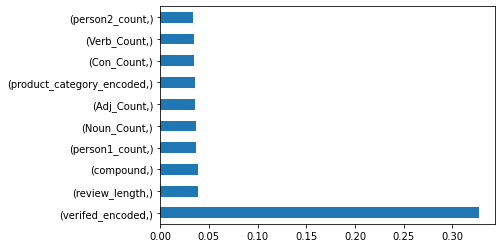

In [58]:
from sklearn.ensemble import ExtraTreesClassifier
import matplotlib.pyplot as plt
model = ExtraTreesClassifier()
model.fit(x_all_features_df,y)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=x_all_features_df.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

In [59]:
x_all_features_df_imp=x_all_features_df[['person2_count','Verb_Count','Con_Count','product_category_encoded','Adj_Count','person1_count','Noun_Count','review_length','compound','verifed_encoded']]

In [73]:
train_accuracy=[]
test_accuracy=[]
y_test_pred_lr=[]
def build_model(_x,_y):
    rfc=RandomForestClassifier()
    lr=LogisticRegression()
    X_train, X_test, y_train, y_test = train_test_split(_x,_y,test_size=0.3,train_size=0.7,random_state=22)
    lr_mdl=lr.fit(X_train,y_train)
    rfc_mdl=rfc.fit(X_train, y_train)
    pred_lr=y_test_pred_lr.append(lr_mdl.predict(X_test))
    
    rfc_train_pred=rfc_mdl.predict(X_train)
    lr_train_pred=lr_mdl.predict(X_train)
    rfc_test_pred=rfc_mdl.predict(X_test)
    lr_test_pred=lr_mdl.predict(X_test)

    rfc_train_mse=mean_squared_error(rfc_train_pred,y_train)
    lr_train_mse=mean_squared_error(lr_train_pred,y_train)
    rfc_test_mse=mean_squared_error(rfc_test_pred,y_test)
    lr_test_mse=mean_squared_error(lr_test_pred,y_test)

    rfc_train_score=accuracy_score(rfc_train_pred,y_train)
    lr_train_score=accuracy_score(lr_train_pred,y_train)
    rfc_test_score=accuracy_score(rfc_test_pred,y_test)
    lr_test_score=accuracy_score(lr_test_pred,y_test)

    
    train_accuracy.append({"Random Forest_acc":rfc_train_score,"Logistic Regression_acc":lr_train_score,"Random Forest_mse":rfc_train_mse,"Logistic Regression_mse":lr_train_mse})
    test_accuracy.append({"Random Forest_acc":rfc_test_score,"Logistic Regression_acc":lr_test_score,"Random Forest_mse":rfc_test_mse,"Logistic Regression_mse":lr_test_mse})
    print("success")


In [74]:
data=[x,x_readabilty_df,x_pos_df,x_structural_df,x_imp_features]
for d in data:
    build_model(d,y)

success
success
success
success
success


In [76]:
train_accuracy 

[{'Random Forest_acc': 0.894822777059664,
  'Logistic Regression_acc': 0.6741955235050003,
  'Random Forest_mse': 0.10517722294033607,
  'Logistic Regression_mse': 0.32580447649499966},
 {'Random Forest_acc': 0.9955779304714606,
  'Logistic Regression_acc': 0.6814068984284645,
  'Random Forest_mse': 0.004422069528539356,
  'Logistic Regression_mse': 0.3185931015715355},
 {'Random Forest_acc': 1.0,
  'Logistic Regression_acc': 0.687529763929519,
  'Random Forest_mse': 0.0,
  'Logistic Regression_mse': 0.31247023607048097},
 {'Random Forest_acc': 0.9878903326756923,
  'Logistic Regression_acc': 0.682699503367576,
  'Random Forest_mse': 0.012109667324307776,
  'Logistic Regression_mse': 0.317300496632424},
 {'Random Forest_acc': 1.0,
  'Logistic Regression_acc': 0.8136607932512416,
  'Random Forest_mse': 0.0,
  'Logistic Regression_mse': 0.18633920674875842}]

In [77]:
test_accuracy

[{'Random Forest_acc': 0.556984126984127,
  'Logistic Regression_acc': 0.5677777777777778,
  'Random Forest_mse': 0.44301587301587303,
  'Logistic Regression_mse': 0.43222222222222223},
 {'Random Forest_acc': 0.5712698412698413,
  'Logistic Regression_acc': 0.5785714285714286,
  'Random Forest_mse': 0.42873015873015874,
  'Logistic Regression_mse': 0.42142857142857143},
 {'Random Forest_acc': 0.6020634920634921,
  'Logistic Regression_acc': 0.586031746031746,
  'Random Forest_mse': 0.3979365079365079,
  'Logistic Regression_mse': 0.413968253968254},
 {'Random Forest_acc': 0.586031746031746,
  'Logistic Regression_acc': 0.5768253968253968,
  'Random Forest_mse': 0.413968253968254,
  'Logistic Regression_mse': 0.42317460317460315},
 {'Random Forest_acc': 0.7996825396825397,
  'Logistic Regression_acc': 0.796031746031746,
  'Random Forest_mse': 0.2003174603174603,
  'Logistic Regression_mse': 0.20396825396825397}]

# Principal Component Analysis

In [ ]:
pca = PCA(n_components=2)
pcs = pca.fit_transform(x_all_features_df)


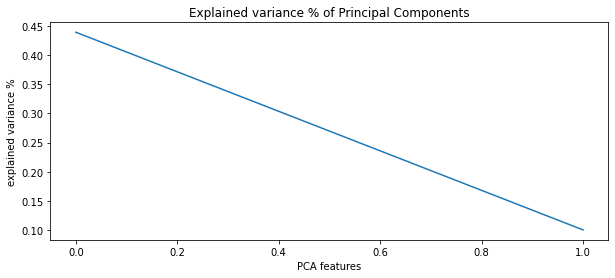

In [ ]:
# https://github.com/aeddeb/Detecting-Fake-Reviews-using-Unsupervised-Learning/blob/master/5_pca_and_modelling.ipynb
plt.figure(figsize=(10,4))
plt.plot(pca.explained_variance_ratio_)
plt.xlabel('PCA features')
plt.ylabel('explained variance %')
plt.title('Explained variance % of Principal Components')
plt.show()

In [ ]:
PCA_components = pd.DataFrame(pcs)
PCA_components

,0,1
0,-2.049367,0.573957
1,0.485071,-0.920601
2,-0.203173,0.376325
3,-1.070798,0.717446
4,-0.518888,-0.567794
...,...,...
20995,-1.967584,0.444990
20996,-1.349527,-0.273756
20997,-0.781519,-0.995208
20998,-0.718218,-0.224794


In [ ]:
kmeans_model = KMeans(n_clusters=3,  verbose=1)
kmeans_model.fit(PCA_components)

Initialization complete
Iteration 0, inertia 137920.90469446997.
Iteration 1, inertia 116450.26404412539.
Iteration 2, inertia 112698.29409011484.
Iteration 3, inertia 109808.58757482974.
Iteration 4, inertia 107531.09621404858.
Iteration 5, inertia 105536.69553527437.
Iteration 6, inertia 104090.80701039925.
Iteration 7, inertia 103055.76823748648.
Iteration 8, inertia 102354.4939541622.
Iteration 9, inertia 101839.4302641215.
Iteration 10, inertia 101561.08610915398.
Iteration 11, inertia 101378.43660561848.
Iteration 12, inertia 101266.23708494089.
Iteration 13, inertia 101170.6216598484.
Iteration 14, inertia 101126.79030246609.
Iteration 15, inertia 101096.34315619574.
Iteration 16, inertia 101064.27628018489.
Iteration 17, inertia 101053.88689888942.
Iteration 18, inertia 101049.86601199779.
Iteration 19, inertia 101042.91389192002.
Iteration 20, inertia 101038.0784143107.
Iteration 21, inertia 101029.66550962024.
Iteration 22, inertia 101021.93973620706.
Iteration 23, inertia 10

KMeans(n_clusters=3, verbose=1)

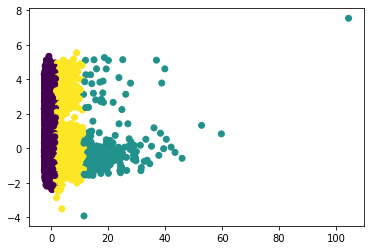

In [ ]:
plt.figure()
plt.scatter(PCA_components[0],PCA_components[1], c=kmeans_model.labels_)
plt.show()